In [10]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType
import matplotlib.pyplot as plt


# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model

In [3]:
# 분류 task
is_classification = True

### ResNet

In [21]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [22]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [23]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [25]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [10000, 30000, 50000, 70000, 100000, 150000, 200000]
resnet_results = []

for size in data_sizes:
    df = pd.read_csv("thyroid_cancer_risk_data.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Age" : numerical,
                "Gender" : categorical,
                "Country" : categorical,
                "Ethnicity" : categorical,
                "Family_History" : categorical,
                "Radiation_Exposure" : categorical,
                "Iodine_Deficiency" : categorical,
                "Smoking" : categorical,
                "Obesity" : categorical,
                "Diabetes" : categorical,
                "TSH_Level" : numerical,
                "T3_Level" : numerical,
                "T4_Level" : numerical,
                "Nodule_Size" : categorical,
                "Thyroid_Cancer_Risk" : categorical,
                "Diagnosis" : categorical}

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
        stype.categorical: EmbeddingEncoder(),
        stype.numerical: numerical_encoder,
    }
    
    if is_classification:
        #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
        output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
    else:
        output_channels = 1
    

    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)

    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')

    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    
    # 훈련 및 테스트
    if is_classification:
        metric = 'Acc'
        best_val_metric = 0
        best_test_metric = 0
    else:
        metric = 'RMSE'
        best_val_metric = float('inf')
        best_test_metric = float('inf')

    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        test_metric = test(test_loader)

        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric

        print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
                f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

        print(f'Best Val {metric}: {best_val_metric:.4f}, '
                f'Best Test {metric}: {best_test_metric:.4f}')
        
    resnet_results.append(best_test_metric)
    


Epoch: 1: 100%|██████████| 24/24 [00:00<00:00, 81.69it/s]


Train Loss: 0.5083, Train Acc: 0.8247, Val Acc: 0.8240, Test Acc: 0.8263
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 2: 100%|██████████| 24/24 [00:00<00:00, 84.57it/s]


Train Loss: 0.4598, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8267
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 3: 100%|██████████| 24/24 [00:00<00:00, 112.59it/s]


Train Loss: 0.4541, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 4: 100%|██████████| 24/24 [00:00<00:00, 136.51it/s]


Train Loss: 0.4524, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8267
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 5: 100%|██████████| 24/24 [00:00<00:00, 96.54it/s]


Train Loss: 0.4497, Train Acc: 0.8270, Val Acc: 0.8240, Test Acc: 0.8250
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 6: 100%|██████████| 24/24 [00:00<00:00, 87.06it/s]


Train Loss: 0.4457, Train Acc: 0.8252, Val Acc: 0.8240, Test Acc: 0.8263
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 7: 100%|██████████| 24/24 [00:00<00:00, 78.12it/s]


Train Loss: 0.4443, Train Acc: 0.8250, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 8: 100%|██████████| 24/24 [00:00<00:00, 68.09it/s]


Train Loss: 0.4385, Train Acc: 0.8252, Val Acc: 0.8240, Test Acc: 0.8263
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 9: 100%|██████████| 24/24 [00:00<00:00, 81.33it/s]


Train Loss: 0.4343, Train Acc: 0.8277, Val Acc: 0.8210, Test Acc: 0.8243
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 10: 100%|██████████| 24/24 [00:00<00:00, 84.31it/s]


Train Loss: 0.4304, Train Acc: 0.8267, Val Acc: 0.8220, Test Acc: 0.8250
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 11: 100%|██████████| 24/24 [00:00<00:00, 100.04it/s]


Train Loss: 0.4292, Train Acc: 0.8290, Val Acc: 0.8200, Test Acc: 0.8227
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 12: 100%|██████████| 24/24 [00:00<00:00, 81.62it/s]


Train Loss: 0.4280, Train Acc: 0.8357, Val Acc: 0.8120, Test Acc: 0.8153
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 13: 100%|██████████| 24/24 [00:00<00:00, 85.29it/s]


Train Loss: 0.4172, Train Acc: 0.8292, Val Acc: 0.8230, Test Acc: 0.8237
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 14: 100%|██████████| 24/24 [00:00<00:00, 84.03it/s]


Train Loss: 0.4167, Train Acc: 0.8350, Val Acc: 0.8210, Test Acc: 0.8233
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 15: 100%|██████████| 24/24 [00:00<00:00, 84.08it/s]


Train Loss: 0.4147, Train Acc: 0.8327, Val Acc: 0.8230, Test Acc: 0.8183
Best Val Acc: 0.8240, Best Test Acc: 0.8263


Epoch: 1: 100%|██████████| 71/71 [00:00<00:00, 82.76it/s]


Train Loss: 0.4710, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 2: 100%|██████████| 71/71 [00:00<00:00, 83.25it/s]


Train Loss: 0.4579, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 3: 100%|██████████| 71/71 [00:00<00:00, 83.30it/s]


Train Loss: 0.4578, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 4: 100%|██████████| 71/71 [00:00<00:00, 82.74it/s]


Train Loss: 0.4560, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 5: 100%|██████████| 71/71 [00:00<00:00, 83.56it/s]


Train Loss: 0.4539, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 6: 100%|██████████| 71/71 [00:00<00:00, 85.40it/s]


Train Loss: 0.4519, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 7: 100%|██████████| 71/71 [00:00<00:00, 84.38it/s]


Train Loss: 0.4524, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 8: 100%|██████████| 71/71 [00:00<00:00, 83.02it/s]


Train Loss: 0.4495, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8266
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 9: 100%|██████████| 71/71 [00:00<00:00, 85.36it/s]


Train Loss: 0.4485, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8266
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 10: 100%|██████████| 71/71 [00:00<00:00, 81.35it/s]


Train Loss: 0.4477, Train Acc: 0.8256, Val Acc: 0.8190, Test Acc: 0.8266
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 11: 100%|██████████| 71/71 [00:00<00:00, 83.28it/s]


Train Loss: 0.4464, Train Acc: 0.8267, Val Acc: 0.8190, Test Acc: 0.8260
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 12: 100%|██████████| 71/71 [00:00<00:00, 88.73it/s] 


Train Loss: 0.4441, Train Acc: 0.8258, Val Acc: 0.8190, Test Acc: 0.8264
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 13: 100%|██████████| 71/71 [00:00<00:00, 92.75it/s]


Train Loss: 0.4444, Train Acc: 0.8274, Val Acc: 0.8170, Test Acc: 0.8249
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 14: 100%|██████████| 71/71 [00:00<00:00, 82.09it/s]


Train Loss: 0.4400, Train Acc: 0.8279, Val Acc: 0.8167, Test Acc: 0.8231
Best Val Acc: 0.8190, Best Test Acc: 0.8267


Epoch: 15: 100%|██████████| 71/71 [00:00<00:00, 91.62it/s]


Train Loss: 0.4417, Train Acc: 0.8266, Val Acc: 0.8193, Test Acc: 0.8254
Best Val Acc: 0.8193, Best Test Acc: 0.8254


Epoch: 1: 100%|██████████| 118/118 [00:01<00:00, 91.87it/s]


Train Loss: 0.4734, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 2: 100%|██████████| 118/118 [00:01<00:00, 81.14it/s]


Train Loss: 0.4584, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 3: 100%|██████████| 118/118 [00:01<00:00, 84.06it/s]


Train Loss: 0.4562, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 4: 100%|██████████| 118/118 [00:01<00:00, 83.76it/s]


Train Loss: 0.4545, Train Acc: 0.8254, Val Acc: 0.8214, Test Acc: 0.8222
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 5: 100%|██████████| 118/118 [00:01<00:00, 86.89it/s]


Train Loss: 0.4533, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 6: 100%|██████████| 118/118 [00:01<00:00, 82.20it/s]


Train Loss: 0.4530, Train Acc: 0.8254, Val Acc: 0.8214, Test Acc: 0.8221
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 7: 100%|██████████| 118/118 [00:01<00:00, 84.86it/s]


Train Loss: 0.4519, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 8: 100%|██████████| 118/118 [00:01<00:00, 84.33it/s]


Train Loss: 0.4513, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 9: 100%|██████████| 118/118 [00:01<00:00, 86.40it/s]


Train Loss: 0.4504, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 10: 100%|██████████| 118/118 [00:01<00:00, 96.05it/s]


Train Loss: 0.4498, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 11: 100%|██████████| 118/118 [00:01<00:00, 81.29it/s]


Train Loss: 0.4491, Train Acc: 0.8264, Val Acc: 0.8188, Test Acc: 0.8187
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 12: 100%|██████████| 118/118 [00:01<00:00, 90.92it/s]


Train Loss: 0.4475, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 13: 100%|██████████| 118/118 [00:01<00:00, 84.49it/s]


Train Loss: 0.4458, Train Acc: 0.8259, Val Acc: 0.8198, Test Acc: 0.8210
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 14: 100%|██████████| 118/118 [00:01<00:00, 94.41it/s]


Train Loss: 0.4450, Train Acc: 0.8258, Val Acc: 0.8206, Test Acc: 0.8222
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 15: 100%|██████████| 118/118 [00:01<00:00, 83.55it/s]


Train Loss: 0.4437, Train Acc: 0.8259, Val Acc: 0.8208, Test Acc: 0.8221
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 1: 100%|██████████| 165/165 [00:01<00:00, 101.56it/s]


Train Loss: 0.4703, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 2: 100%|██████████| 165/165 [00:01<00:00, 84.41it/s]


Train Loss: 0.4575, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 3: 100%|██████████| 165/165 [00:01<00:00, 93.58it/s]


Train Loss: 0.4557, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 4: 100%|██████████| 165/165 [00:01<00:00, 87.94it/s]


Train Loss: 0.4558, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 5: 100%|██████████| 165/165 [00:01<00:00, 92.32it/s]


Train Loss: 0.4542, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 6: 100%|██████████| 165/165 [00:01<00:00, 90.49it/s]


Train Loss: 0.4540, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 7: 100%|██████████| 165/165 [00:01<00:00, 115.70it/s]


Train Loss: 0.4529, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 8: 100%|██████████| 165/165 [00:01<00:00, 89.97it/s]


Train Loss: 0.4521, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 9: 100%|██████████| 165/165 [00:01<00:00, 90.33it/s]


Train Loss: 0.4514, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 10: 100%|██████████| 165/165 [00:01<00:00, 91.31it/s]


Train Loss: 0.4508, Train Acc: 0.8247, Val Acc: 0.8244, Test Acc: 0.8292
Best Val Acc: 0.8244, Best Test Acc: 0.8292


Epoch: 11: 100%|██████████| 165/165 [00:01<00:00, 90.84it/s]


Train Loss: 0.4502, Train Acc: 0.8243, Val Acc: 0.8191, Test Acc: 0.8230
Best Val Acc: 0.8244, Best Test Acc: 0.8292


Epoch: 12: 100%|██████████| 165/165 [00:01<00:00, 110.72it/s]


Train Loss: 0.4495, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8294
Best Val Acc: 0.8244, Best Test Acc: 0.8292


Epoch: 13: 100%|██████████| 165/165 [00:01<00:00, 89.72it/s]


Train Loss: 0.4481, Train Acc: 0.8253, Val Acc: 0.8203, Test Acc: 0.8254
Best Val Acc: 0.8244, Best Test Acc: 0.8292


Epoch: 14: 100%|██████████| 165/165 [00:01<00:00, 96.94it/s]


Train Loss: 0.4478, Train Acc: 0.8256, Val Acc: 0.8231, Test Acc: 0.8285
Best Val Acc: 0.8244, Best Test Acc: 0.8292


Epoch: 15: 100%|██████████| 165/165 [00:01<00:00, 92.43it/s]


Train Loss: 0.4474, Train Acc: 0.8248, Val Acc: 0.8244, Test Acc: 0.8293
Best Val Acc: 0.8244, Best Test Acc: 0.8292


Epoch: 1: 100%|██████████| 235/235 [00:02<00:00, 86.68it/s]


Train Loss: 0.4626, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 2: 100%|██████████| 235/235 [00:02<00:00, 85.49it/s] 


Train Loss: 0.4550, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 3: 100%|██████████| 235/235 [00:02<00:00, 84.48it/s]


Train Loss: 0.4544, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 4: 100%|██████████| 235/235 [00:02<00:00, 90.11it/s]


Train Loss: 0.4535, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 5: 100%|██████████| 235/235 [00:02<00:00, 85.95it/s]


Train Loss: 0.4528, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 6: 100%|██████████| 235/235 [00:02<00:00, 89.08it/s]


Train Loss: 0.4520, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 7: 100%|██████████| 235/235 [00:02<00:00, 88.36it/s]


Train Loss: 0.4520, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 8: 100%|██████████| 235/235 [00:02<00:00, 90.08it/s]


Train Loss: 0.4516, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 9: 100%|██████████| 235/235 [00:02<00:00, 98.44it/s] 


Train Loss: 0.4510, Train Acc: 0.8259, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 10: 100%|██████████| 235/235 [00:02<00:00, 83.88it/s]


Train Loss: 0.4498, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 11: 100%|██████████| 235/235 [00:02<00:00, 88.05it/s]


Train Loss: 0.4492, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 12: 100%|██████████| 235/235 [00:02<00:00, 84.68it/s]


Train Loss: 0.4491, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 13: 100%|██████████| 235/235 [00:02<00:00, 90.84it/s]


Train Loss: 0.4478, Train Acc: 0.8259, Val Acc: 0.8278, Test Acc: 0.8271
Best Val Acc: 0.8278, Best Test Acc: 0.8271


Epoch: 14: 100%|██████████| 235/235 [00:02<00:00, 88.10it/s]


Train Loss: 0.4475, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8278, Best Test Acc: 0.8271


Epoch: 15: 100%|██████████| 235/235 [00:02<00:00, 83.18it/s]


Train Loss: 0.4458, Train Acc: 0.8259, Val Acc: 0.8277, Test Acc: 0.8276
Best Val Acc: 0.8278, Best Test Acc: 0.8271


Epoch: 1: 100%|██████████| 352/352 [00:04<00:00, 86.38it/s]


Train Loss: 0.4600, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 2: 100%|██████████| 352/352 [00:03<00:00, 91.59it/s] 


Train Loss: 0.4537, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 3: 100%|██████████| 352/352 [00:04<00:00, 86.89it/s]


Train Loss: 0.4523, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 4: 100%|██████████| 352/352 [00:04<00:00, 84.55it/s]


Train Loss: 0.4522, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 5: 100%|██████████| 352/352 [00:04<00:00, 82.25it/s]


Train Loss: 0.4517, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 6: 100%|██████████| 352/352 [00:04<00:00, 85.18it/s]


Train Loss: 0.4513, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 7: 100%|██████████| 352/352 [00:04<00:00, 81.47it/s]


Train Loss: 0.4511, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 8: 100%|██████████| 352/352 [00:03<00:00, 88.52it/s]


Train Loss: 0.4506, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 9: 100%|██████████| 352/352 [00:04<00:00, 86.02it/s]


Train Loss: 0.4499, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 10: 100%|██████████| 352/352 [00:04<00:00, 86.90it/s]


Train Loss: 0.4498, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 11: 100%|██████████| 352/352 [00:04<00:00, 85.15it/s]


Train Loss: 0.4492, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8292
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 12: 100%|██████████| 352/352 [00:04<00:00, 82.56it/s]


Train Loss: 0.4487, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 13: 100%|██████████| 352/352 [00:04<00:00, 82.65it/s]


Train Loss: 0.4480, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 14: 100%|██████████| 352/352 [00:04<00:00, 85.00it/s]


Train Loss: 0.4474, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 15: 100%|██████████| 352/352 [00:04<00:00, 81.64it/s]


Train Loss: 0.4464, Train Acc: 0.8270, Val Acc: 0.8253, Test Acc: 0.8291
Best Val Acc: 0.8253, Best Test Acc: 0.8291


Epoch: 1: 100%|██████████| 469/469 [00:05<00:00, 83.83it/s]


Train Loss: 0.4586, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 2: 100%|██████████| 469/469 [00:05<00:00, 85.95it/s] 


Train Loss: 0.4531, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 3: 100%|██████████| 469/469 [00:05<00:00, 85.05it/s] 


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 4: 100%|██████████| 469/469 [00:05<00:00, 84.04it/s]


Train Loss: 0.4516, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 5: 100%|██████████| 469/469 [00:05<00:00, 83.86it/s]


Train Loss: 0.4514, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 6: 100%|██████████| 469/469 [00:05<00:00, 84.98it/s]


Train Loss: 0.4511, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 7: 100%|██████████| 469/469 [00:05<00:00, 85.25it/s]


Train Loss: 0.4507, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 8: 100%|██████████| 469/469 [00:05<00:00, 84.32it/s]


Train Loss: 0.4504, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 9: 100%|██████████| 469/469 [00:05<00:00, 82.13it/s]


Train Loss: 0.4502, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 10: 100%|██████████| 469/469 [00:05<00:00, 82.53it/s]


Train Loss: 0.4498, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 11: 100%|██████████| 469/469 [00:05<00:00, 91.27it/s] 


Train Loss: 0.4493, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 12: 100%|██████████| 469/469 [00:05<00:00, 87.03it/s] 


Train Loss: 0.4489, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 13: 100%|██████████| 469/469 [00:05<00:00, 91.49it/s] 


Train Loss: 0.4480, Train Acc: 0.8272, Val Acc: 0.8303, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 14: 100%|██████████| 469/469 [00:05<00:00, 88.79it/s] 


Train Loss: 0.4478, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 15: 100%|██████████| 469/469 [00:05<00:00, 86.00it/s]


Train Loss: 0.4468, Train Acc: 0.8272, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


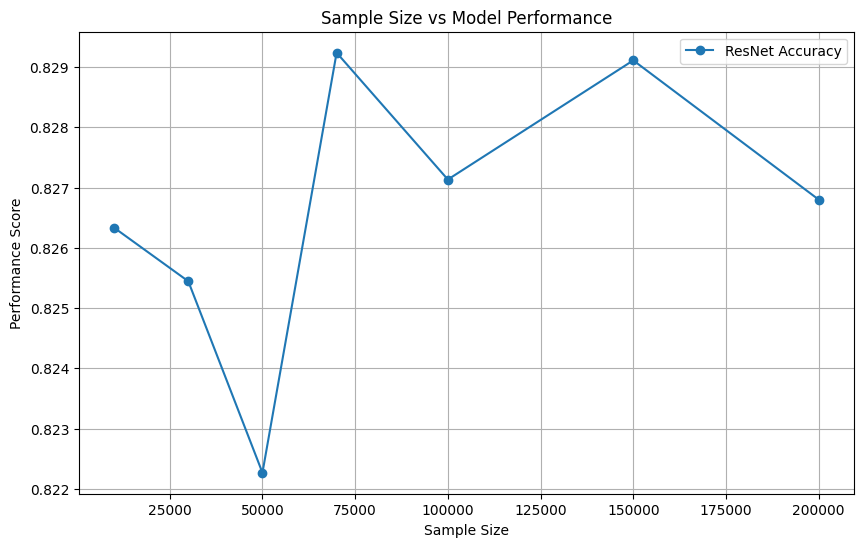

In [26]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, resnet_results, marker="o", linestyle="-", label="ResNet Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

### FT-T

In [27]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [28]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [29]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [30]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [10000, 30000, 50000, 70000, 100000, 150000, 200000]
ftt_results = []

for size in data_sizes:
    df = pd.read_csv("thyroid_cancer_risk_data.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Age" : numerical,
                "Gender" : categorical,
                "Country" : categorical,
                "Ethnicity" : categorical,
                "Family_History" : categorical,
                "Radiation_Exposure" : categorical,
                "Iodine_Deficiency" : categorical,
                "Smoking" : categorical,
                "Obesity" : categorical,
                "Diabetes" : categorical,
                "TSH_Level" : numerical,
                "T3_Level" : numerical,
                "T4_Level" : numerical,
                "Nodule_Size" : categorical,
                "Thyroid_Cancer_Risk" : categorical,
                "Diagnosis" : categorical}

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
        stype.categorical: EmbeddingEncoder(),
        stype.numerical: numerical_encoder,
    }
    
    if is_classification:
        #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
        output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
    else:
        output_channels = 1
    

    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)

    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels=output_channels,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')

    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    
    # 훈련 및 테스트
    if is_classification:
        metric = 'Acc'
        best_val_metric = 0
        best_test_metric = 0
    else:
        metric = 'RMSE'
        best_val_metric = float('inf')
        best_test_metric = float('inf')

    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        test_metric = test(test_loader)

        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric

        print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
                f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

        print(f'Best Val {metric}: {best_val_metric:.4f}, '
                f'Best Test {metric}: {best_test_metric:.4f}')
        
    ftt_results.append(best_test_metric)
    

Epoch: 1: 100%|██████████| 24/24 [00:00<00:00, 54.09it/s]


Train Loss: 0.5793, Train Acc: 0.7698, Val Acc: 0.7570, Test Acc: 0.7613
Best Val Acc: 0.7570, Best Test Acc: 0.7613


Epoch: 2: 100%|██████████| 24/24 [00:00<00:00, 28.71it/s]


Train Loss: 0.4948, Train Acc: 0.8237, Val Acc: 0.8220, Test Acc: 0.8243
Best Val Acc: 0.8220, Best Test Acc: 0.8243


Epoch: 3: 100%|██████████| 24/24 [00:00<00:00, 39.89it/s]


Train Loss: 0.4630, Train Acc: 0.8250, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 4: 100%|██████████| 24/24 [00:00<00:00, 41.28it/s]


Train Loss: 0.4574, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 5: 100%|██████████| 24/24 [00:00<00:00, 40.42it/s]


Train Loss: 0.4559, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 6: 100%|██████████| 24/24 [00:00<00:00, 40.16it/s]


Train Loss: 0.4548, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 7: 100%|██████████| 24/24 [00:00<00:00, 39.21it/s]


Train Loss: 0.4540, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 8: 100%|██████████| 24/24 [00:00<00:00, 38.42it/s]


Train Loss: 0.4538, Train Acc: 0.8250, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 9: 100%|██████████| 24/24 [00:00<00:00, 40.91it/s]


Train Loss: 0.4551, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 10: 100%|██████████| 24/24 [00:00<00:00, 38.81it/s]


Train Loss: 0.4494, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 11: 100%|██████████| 24/24 [00:00<00:00, 42.49it/s]


Train Loss: 0.4527, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8240, Best Test Acc: 0.8270


Epoch: 12: 100%|██████████| 24/24 [00:00<00:00, 40.25it/s]


Train Loss: 0.4511, Train Acc: 0.8252, Val Acc: 0.8250, Test Acc: 0.8270
Best Val Acc: 0.8250, Best Test Acc: 0.8270


Epoch: 13: 100%|██████████| 24/24 [00:00<00:00, 39.95it/s]


Train Loss: 0.4503, Train Acc: 0.8250, Val Acc: 0.8250, Test Acc: 0.8270
Best Val Acc: 0.8250, Best Test Acc: 0.8270


Epoch: 14: 100%|██████████| 24/24 [00:00<00:00, 40.08it/s]


Train Loss: 0.4513, Train Acc: 0.8248, Val Acc: 0.8240, Test Acc: 0.8270
Best Val Acc: 0.8250, Best Test Acc: 0.8270


Epoch: 15: 100%|██████████| 24/24 [00:00<00:00, 39.58it/s]


Train Loss: 0.4498, Train Acc: 0.8250, Val Acc: 0.8250, Test Acc: 0.8270
Best Val Acc: 0.8250, Best Test Acc: 0.8270


Epoch: 1: 100%|██████████| 71/71 [00:01<00:00, 47.88it/s]


Train Loss: 0.5010, Train Acc: 0.8253, Val Acc: 0.8190, Test Acc: 0.8264
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 2: 100%|██████████| 71/71 [00:01<00:00, 38.36it/s]


Train Loss: 0.4632, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 3: 100%|██████████| 71/71 [00:01<00:00, 41.27it/s]


Train Loss: 0.4597, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 4: 100%|██████████| 71/71 [00:01<00:00, 43.09it/s]


Train Loss: 0.4572, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 5: 100%|██████████| 71/71 [00:01<00:00, 40.23it/s]


Train Loss: 0.4564, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 6: 100%|██████████| 71/71 [00:01<00:00, 40.80it/s]


Train Loss: 0.4576, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 7: 100%|██████████| 71/71 [00:01<00:00, 38.20it/s]


Train Loss: 0.4557, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 8: 100%|██████████| 71/71 [00:01<00:00, 35.74it/s]


Train Loss: 0.4556, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 9: 100%|██████████| 71/71 [00:01<00:00, 35.58it/s]


Train Loss: 0.4551, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 10: 100%|██████████| 71/71 [00:01<00:00, 36.37it/s]


Train Loss: 0.4549, Train Acc: 0.8258, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 11: 100%|██████████| 71/71 [00:01<00:00, 40.59it/s]


Train Loss: 0.4556, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 12: 100%|██████████| 71/71 [00:01<00:00, 38.69it/s]


Train Loss: 0.4545, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 13: 100%|██████████| 71/71 [00:01<00:00, 38.45it/s]


Train Loss: 0.4538, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 14: 100%|██████████| 71/71 [00:01<00:00, 43.07it/s]


Train Loss: 0.4534, Train Acc: 0.8258, Val Acc: 0.8190, Test Acc: 0.8266
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 15: 100%|██████████| 71/71 [00:01<00:00, 41.32it/s]


Train Loss: 0.4528, Train Acc: 0.8258, Val Acc: 0.8190, Test Acc: 0.8266
Best Val Acc: 0.8190, Best Test Acc: 0.8264


Epoch: 1: 100%|██████████| 118/118 [00:02<00:00, 39.94it/s]


Train Loss: 0.4833, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 2: 100%|██████████| 118/118 [00:03<00:00, 38.84it/s]


Train Loss: 0.4591, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 3: 100%|██████████| 118/118 [00:02<00:00, 41.72it/s]


Train Loss: 0.4577, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 4: 100%|██████████| 118/118 [00:02<00:00, 42.81it/s]


Train Loss: 0.4564, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 5: 100%|██████████| 118/118 [00:03<00:00, 39.25it/s]


Train Loss: 0.4564, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 6: 100%|██████████| 118/118 [00:02<00:00, 39.62it/s]


Train Loss: 0.4561, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 7: 100%|██████████| 118/118 [00:02<00:00, 39.97it/s]


Train Loss: 0.4560, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 8: 100%|██████████| 118/118 [00:02<00:00, 43.21it/s]


Train Loss: 0.4550, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 9: 100%|██████████| 118/118 [00:03<00:00, 38.00it/s]


Train Loss: 0.4552, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 10: 100%|██████████| 118/118 [00:02<00:00, 40.85it/s]


Train Loss: 0.4547, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 11: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s]


Train Loss: 0.4547, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 12: 100%|██████████| 118/118 [00:02<00:00, 39.49it/s]


Train Loss: 0.4546, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 13: 100%|██████████| 118/118 [00:02<00:00, 43.41it/s]


Train Loss: 0.4538, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 14: 100%|██████████| 118/118 [00:03<00:00, 38.07it/s]


Train Loss: 0.4532, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 15: 100%|██████████| 118/118 [00:03<00:00, 36.79it/s]


Train Loss: 0.4533, Train Acc: 0.8254, Val Acc: 0.8214, Test Acc: 0.8222
Best Val Acc: 0.8214, Best Test Acc: 0.8223


Epoch: 1: 100%|██████████| 165/165 [00:04<00:00, 40.88it/s]


Train Loss: 0.4754, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 2: 100%|██████████| 165/165 [00:04<00:00, 40.33it/s]


Train Loss: 0.4592, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 3: 100%|██████████| 165/165 [00:03<00:00, 41.58it/s]


Train Loss: 0.4576, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 4: 100%|██████████| 165/165 [00:04<00:00, 35.66it/s]


Train Loss: 0.4573, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 5: 100%|██████████| 165/165 [00:04<00:00, 37.26it/s]


Train Loss: 0.4568, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 6: 100%|██████████| 165/165 [00:04<00:00, 40.60it/s]


Train Loss: 0.4564, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 7: 100%|██████████| 165/165 [00:03<00:00, 41.59it/s]


Train Loss: 0.4558, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 8: 100%|██████████| 165/165 [00:04<00:00, 41.22it/s]


Train Loss: 0.4560, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 9: 100%|██████████| 165/165 [00:03<00:00, 42.44it/s]


Train Loss: 0.4558, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 10: 100%|██████████| 165/165 [00:04<00:00, 41.16it/s]


Train Loss: 0.4556, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 11: 100%|██████████| 165/165 [00:01<00:00, 84.14it/s]


Train Loss: 0.4556, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 12: 100%|██████████| 165/165 [00:04<00:00, 37.77it/s]


Train Loss: 0.4554, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 13: 100%|██████████| 165/165 [00:04<00:00, 37.67it/s]


Train Loss: 0.4553, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 14: 100%|██████████| 165/165 [00:03<00:00, 44.68it/s]


Train Loss: 0.4547, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 15: 100%|██████████| 165/165 [00:03<00:00, 41.99it/s]


Train Loss: 0.4548, Train Acc: 0.8247, Val Acc: 0.8243, Test Acc: 0.8295
Best Val Acc: 0.8243, Best Test Acc: 0.8295


Epoch: 1: 100%|██████████| 235/235 [00:05<00:00, 42.37it/s]


Train Loss: 0.4709, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 2: 100%|██████████| 235/235 [00:05<00:00, 39.57it/s]


Train Loss: 0.4563, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 3: 100%|██████████| 235/235 [00:05<00:00, 41.45it/s]


Train Loss: 0.4552, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 4: 100%|██████████| 235/235 [00:05<00:00, 42.54it/s]


Train Loss: 0.4553, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 5: 100%|██████████| 235/235 [00:05<00:00, 39.66it/s]


Train Loss: 0.4546, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 6: 100%|██████████| 235/235 [00:05<00:00, 41.37it/s]


Train Loss: 0.4542, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 7: 100%|██████████| 235/235 [00:05<00:00, 41.77it/s]


Train Loss: 0.4541, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 8: 100%|██████████| 235/235 [00:06<00:00, 37.45it/s]


Train Loss: 0.4538, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 9: 100%|██████████| 235/235 [00:05<00:00, 40.27it/s]


Train Loss: 0.4538, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 10: 100%|██████████| 235/235 [00:05<00:00, 41.21it/s]


Train Loss: 0.4538, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 11: 100%|██████████| 235/235 [00:05<00:00, 41.03it/s]


Train Loss: 0.4536, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 12: 100%|██████████| 235/235 [00:05<00:00, 43.88it/s]


Train Loss: 0.4534, Train Acc: 0.8258, Val Acc: 0.8277, Test Acc: 0.8275
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 13: 100%|██████████| 235/235 [00:05<00:00, 40.47it/s]


Train Loss: 0.4535, Train Acc: 0.8260, Val Acc: 0.8278, Test Acc: 0.8273
Best Val Acc: 0.8278, Best Test Acc: 0.8273


Epoch: 14: 100%|██████████| 235/235 [00:05<00:00, 40.87it/s]


Train Loss: 0.4531, Train Acc: 0.8261, Val Acc: 0.8277, Test Acc: 0.8273
Best Val Acc: 0.8278, Best Test Acc: 0.8273


Epoch: 15: 100%|██████████| 235/235 [00:06<00:00, 38.64it/s]


Train Loss: 0.4529, Train Acc: 0.8260, Val Acc: 0.8278, Test Acc: 0.8274
Best Val Acc: 0.8278, Best Test Acc: 0.8273


Epoch: 1: 100%|██████████| 352/352 [00:08<00:00, 39.70it/s]


Train Loss: 0.4631, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 2: 100%|██████████| 352/352 [00:08<00:00, 40.59it/s]


Train Loss: 0.4543, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 3: 100%|██████████| 352/352 [00:08<00:00, 40.30it/s]


Train Loss: 0.4539, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 4: 100%|██████████| 352/352 [00:05<00:00, 64.87it/s]


Train Loss: 0.4529, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 5: 100%|██████████| 352/352 [00:08<00:00, 42.27it/s]


Train Loss: 0.4527, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 6: 100%|██████████| 352/352 [00:08<00:00, 40.06it/s]


Train Loss: 0.4526, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 7: 100%|██████████| 352/352 [00:08<00:00, 41.59it/s]


Train Loss: 0.4524, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 8: 100%|██████████| 352/352 [00:08<00:00, 41.03it/s]


Train Loss: 0.4524, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 9: 100%|██████████| 352/352 [00:08<00:00, 41.20it/s]


Train Loss: 0.4524, Train Acc: 0.8268, Val Acc: 0.8251, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 10: 100%|██████████| 352/352 [00:08<00:00, 40.62it/s]


Train Loss: 0.4522, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 11: 100%|██████████| 352/352 [00:08<00:00, 40.14it/s]


Train Loss: 0.4521, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 12: 100%|██████████| 352/352 [00:08<00:00, 41.88it/s]


Train Loss: 0.4521, Train Acc: 0.8268, Val Acc: 0.8251, Test Acc: 0.8290
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 13: 100%|██████████| 352/352 [00:08<00:00, 41.29it/s]


Train Loss: 0.4520, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 14: 100%|██████████| 352/352 [00:08<00:00, 40.84it/s]


Train Loss: 0.4518, Train Acc: 0.8268, Val Acc: 0.8249, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 15: 100%|██████████| 352/352 [00:08<00:00, 41.68it/s]


Train Loss: 0.4518, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291
Best Val Acc: 0.8252, Best Test Acc: 0.8291


Epoch: 1: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s]


Train Loss: 0.4605, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 2: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]


Train Loss: 0.4534, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 3: 100%|██████████| 469/469 [00:11<00:00, 39.84it/s]


Train Loss: 0.4529, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 4: 100%|██████████| 469/469 [00:12<00:00, 38.20it/s]


Train Loss: 0.4525, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 5: 100%|██████████| 469/469 [00:10<00:00, 43.05it/s]


Train Loss: 0.4524, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 6: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]


Train Loss: 0.4522, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 7: 100%|██████████| 469/469 [00:11<00:00, 42.36it/s]


Train Loss: 0.4521, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 8: 100%|██████████| 469/469 [00:11<00:00, 40.48it/s]


Train Loss: 0.4519, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 9: 100%|██████████| 469/469 [00:11<00:00, 40.02it/s]


Train Loss: 0.4520, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 10: 100%|██████████| 469/469 [00:11<00:00, 40.79it/s]


Train Loss: 0.4518, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 11: 100%|██████████| 469/469 [00:11<00:00, 41.08it/s]


Train Loss: 0.4518, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 12: 100%|██████████| 469/469 [00:11<00:00, 39.26it/s]


Train Loss: 0.4518, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 13: 100%|██████████| 469/469 [00:11<00:00, 41.45it/s]


Train Loss: 0.4516, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 14: 100%|██████████| 469/469 [00:12<00:00, 38.79it/s]


Train Loss: 0.4516, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268
Best Val Acc: 0.8304, Best Test Acc: 0.8268


Epoch: 15: 100%|██████████| 469/469 [00:11<00:00, 40.95it/s]


Train Loss: 0.4515, Train Acc: 0.8271, Val Acc: 0.8303, Test Acc: 0.8266
Best Val Acc: 0.8304, Best Test Acc: 0.8268


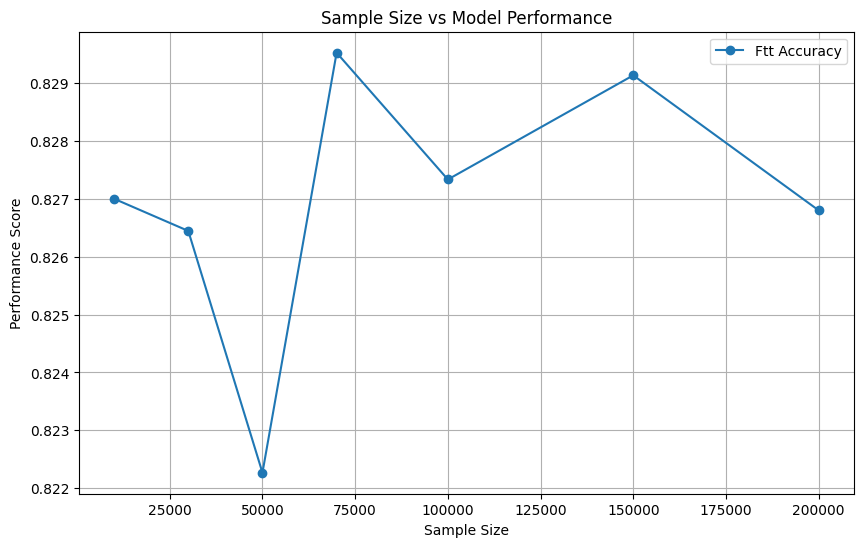

In [31]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, ftt_results, marker="o", linestyle="-", label="Ftt Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

### TabNet

In [32]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [33]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [34]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [10000, 30000, 50000, 70000, 100000, 150000, 200000]
tabnet_results = []

for size in data_sizes:
    df = pd.read_csv("thyroid_cancer_risk_data.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Age" : numerical,
                "Gender" : categorical,
                "Country" : categorical,
                "Ethnicity" : categorical,
                "Family_History" : categorical,
                "Radiation_Exposure" : categorical,
                "Iodine_Deficiency" : categorical,
                "Smoking" : categorical,
                "Obesity" : categorical,
                "Diabetes" : categorical,
                "TSH_Level" : numerical,
                "T3_Level" : numerical,
                "T4_Level" : numerical,
                "Nodule_Size" : categorical,
                "Thyroid_Cancer_Risk" : categorical,
                "Diagnosis" : categorical}

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                              shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

    # Set up model and optimizer
    model = TabNet(
        out_channels = 2,
        num_layers=args.num_layers,
        split_attn_channels=args.channels,
        split_feat_channels=args.channels,
        gamma=args.gamma,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

    
    # 훈련 및 테스트
    best_val_acc = 0
    best_test_acc = 0
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_acc = test(train_loader)
        val_acc = test(val_loader)
        test_acc = test(test_loader)
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
        lr_scheduler.step()

    print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')
        
    tabnet_results.append(best_test_metric)
    

Epoch: 1: 100%|██████████| 24/24 [00:00<00:00, 41.28it/s]


Train Loss: 0.6930, Train Acc: 0.2663, Val Acc: 0.2800, Test Acc: 0.2717


Epoch: 2: 100%|██████████| 24/24 [00:00<00:00, 43.84it/s]


Train Loss: 0.6260, Train Acc: 0.6725, Val Acc: 0.6630, Test Acc: 0.6777


Epoch: 3: 100%|██████████| 24/24 [00:00<00:00, 43.78it/s]


Train Loss: 0.5433, Train Acc: 0.7808, Val Acc: 0.7820, Test Acc: 0.7813


Epoch: 4: 100%|██████████| 24/24 [00:00<00:00, 42.22it/s]


Train Loss: 0.4849, Train Acc: 0.8203, Val Acc: 0.8120, Test Acc: 0.8193


Epoch: 5: 100%|██████████| 24/24 [00:00<00:00, 42.47it/s]


Train Loss: 0.4619, Train Acc: 0.8237, Val Acc: 0.8180, Test Acc: 0.8193


Epoch: 6: 100%|██████████| 24/24 [00:00<00:00, 42.25it/s]


Train Loss: 0.4520, Train Acc: 0.8270, Val Acc: 0.8170, Test Acc: 0.8193


Epoch: 7: 100%|██████████| 24/24 [00:00<00:00, 49.40it/s]


Train Loss: 0.4415, Train Acc: 0.8297, Val Acc: 0.8160, Test Acc: 0.8193


Epoch: 8: 100%|██████████| 24/24 [00:00<00:00, 60.81it/s]


Train Loss: 0.4343, Train Acc: 0.8307, Val Acc: 0.8130, Test Acc: 0.8177


Epoch: 9: 100%|██████████| 24/24 [00:00<00:00, 57.05it/s]


Train Loss: 0.4298, Train Acc: 0.8328, Val Acc: 0.8140, Test Acc: 0.8157


Epoch: 10: 100%|██████████| 24/24 [00:00<00:00, 42.30it/s]


Train Loss: 0.4214, Train Acc: 0.8342, Val Acc: 0.8140, Test Acc: 0.8153


Epoch: 11: 100%|██████████| 24/24 [00:00<00:00, 45.59it/s]


Train Loss: 0.4149, Train Acc: 0.8367, Val Acc: 0.8050, Test Acc: 0.8133


Epoch: 12: 100%|██████████| 24/24 [00:00<00:00, 42.70it/s]


Train Loss: 0.4108, Train Acc: 0.8357, Val Acc: 0.8120, Test Acc: 0.8140


Epoch: 13: 100%|██████████| 24/24 [00:00<00:00, 42.63it/s]


Train Loss: 0.4037, Train Acc: 0.8380, Val Acc: 0.8050, Test Acc: 0.8090


Epoch: 14: 100%|██████████| 24/24 [00:00<00:00, 44.03it/s]


Train Loss: 0.3992, Train Acc: 0.8373, Val Acc: 0.8080, Test Acc: 0.8107


Epoch: 15: 100%|██████████| 24/24 [00:00<00:00, 44.20it/s]


Train Loss: 0.3963, Train Acc: 0.8387, Val Acc: 0.8130, Test Acc: 0.8103
Best Val Acc: 0.8180, Best Test Acc: 0.8193


Epoch: 1: 100%|██████████| 71/71 [00:01<00:00, 43.18it/s]


Train Loss: 0.6124, Train Acc: 0.8076, Val Acc: 0.7980, Test Acc: 0.8072


Epoch: 2: 100%|██████████| 71/71 [00:01<00:00, 45.40it/s]


Train Loss: 0.4733, Train Acc: 0.8257, Val Acc: 0.8190, Test Acc: 0.8267


Epoch: 3: 100%|██████████| 71/71 [00:01<00:00, 40.08it/s]


Train Loss: 0.4589, Train Acc: 0.8259, Val Acc: 0.8187, Test Acc: 0.8266


Epoch: 4: 100%|██████████| 71/71 [00:01<00:00, 53.28it/s]


Train Loss: 0.4533, Train Acc: 0.8259, Val Acc: 0.8187, Test Acc: 0.8263


Epoch: 5: 100%|██████████| 71/71 [00:01<00:00, 45.03it/s]


Train Loss: 0.4508, Train Acc: 0.8258, Val Acc: 0.8193, Test Acc: 0.8266


Epoch: 6: 100%|██████████| 71/71 [00:01<00:00, 42.26it/s]


Train Loss: 0.4475, Train Acc: 0.8260, Val Acc: 0.8173, Test Acc: 0.8242


Epoch: 7: 100%|██████████| 71/71 [00:01<00:00, 41.72it/s]


Train Loss: 0.4458, Train Acc: 0.8266, Val Acc: 0.8157, Test Acc: 0.8251


Epoch: 8: 100%|██████████| 71/71 [00:01<00:00, 44.00it/s]


Train Loss: 0.4439, Train Acc: 0.8263, Val Acc: 0.8170, Test Acc: 0.8243


Epoch: 9: 100%|██████████| 71/71 [00:01<00:00, 44.33it/s]


Train Loss: 0.4412, Train Acc: 0.8269, Val Acc: 0.8180, Test Acc: 0.8254


Epoch: 10: 100%|██████████| 71/71 [00:01<00:00, 46.80it/s]


Train Loss: 0.4391, Train Acc: 0.8272, Val Acc: 0.8177, Test Acc: 0.8248


Epoch: 11: 100%|██████████| 71/71 [00:01<00:00, 43.32it/s]


Train Loss: 0.4354, Train Acc: 0.8281, Val Acc: 0.8157, Test Acc: 0.8238


Epoch: 12: 100%|██████████| 71/71 [00:01<00:00, 43.95it/s]


Train Loss: 0.4341, Train Acc: 0.8288, Val Acc: 0.8167, Test Acc: 0.8236


Epoch: 13: 100%|██████████| 71/71 [00:01<00:00, 42.42it/s]


Train Loss: 0.4321, Train Acc: 0.8292, Val Acc: 0.8160, Test Acc: 0.8239


Epoch: 14: 100%|██████████| 71/71 [00:01<00:00, 42.31it/s]


Train Loss: 0.4300, Train Acc: 0.8296, Val Acc: 0.8163, Test Acc: 0.8233


Epoch: 15: 100%|██████████| 71/71 [00:01<00:00, 49.11it/s]


Train Loss: 0.4259, Train Acc: 0.8304, Val Acc: 0.8157, Test Acc: 0.8237
Best Val Acc: 0.8193, Best Test Acc: 0.8266


Epoch: 1: 100%|██████████| 118/118 [00:02<00:00, 43.56it/s]


Train Loss: 0.5551, Train Acc: 0.8252, Val Acc: 0.8216, Test Acc: 0.8221


Epoch: 2: 100%|██████████| 118/118 [00:03<00:00, 37.02it/s]


Train Loss: 0.4636, Train Acc: 0.8253, Val Acc: 0.8214, Test Acc: 0.8223


Epoch: 3: 100%|██████████| 118/118 [00:03<00:00, 36.27it/s]


Train Loss: 0.4561, Train Acc: 0.8254, Val Acc: 0.8198, Test Acc: 0.8219


Epoch: 4: 100%|██████████| 118/118 [00:02<00:00, 39.50it/s]


Train Loss: 0.4544, Train Acc: 0.8255, Val Acc: 0.8212, Test Acc: 0.8221


Epoch: 5: 100%|██████████| 118/118 [00:02<00:00, 41.79it/s]


Train Loss: 0.4525, Train Acc: 0.8259, Val Acc: 0.8210, Test Acc: 0.8217


Epoch: 6: 100%|██████████| 118/118 [00:02<00:00, 46.93it/s]


Train Loss: 0.4503, Train Acc: 0.8257, Val Acc: 0.8208, Test Acc: 0.8217


Epoch: 7: 100%|██████████| 118/118 [00:02<00:00, 43.57it/s]


Train Loss: 0.4488, Train Acc: 0.8262, Val Acc: 0.8204, Test Acc: 0.8216


Epoch: 8: 100%|██████████| 118/118 [00:02<00:00, 45.62it/s]


Train Loss: 0.4481, Train Acc: 0.8265, Val Acc: 0.8202, Test Acc: 0.8215


Epoch: 9: 100%|██████████| 118/118 [00:02<00:00, 42.93it/s]


Train Loss: 0.4468, Train Acc: 0.8272, Val Acc: 0.8204, Test Acc: 0.8219


Epoch: 10: 100%|██████████| 118/118 [00:02<00:00, 47.50it/s]


Train Loss: 0.4448, Train Acc: 0.8267, Val Acc: 0.8186, Test Acc: 0.8210


Epoch: 11: 100%|██████████| 118/118 [00:02<00:00, 42.55it/s]


Train Loss: 0.4431, Train Acc: 0.8270, Val Acc: 0.8200, Test Acc: 0.8205


Epoch: 12: 100%|██████████| 118/118 [00:02<00:00, 42.03it/s]


Train Loss: 0.4403, Train Acc: 0.8270, Val Acc: 0.8184, Test Acc: 0.8198


Epoch: 13: 100%|██████████| 118/118 [00:02<00:00, 42.35it/s]


Train Loss: 0.4398, Train Acc: 0.8280, Val Acc: 0.8190, Test Acc: 0.8195


Epoch: 14: 100%|██████████| 118/118 [00:02<00:00, 42.09it/s]


Train Loss: 0.4385, Train Acc: 0.8279, Val Acc: 0.8180, Test Acc: 0.8204


Epoch: 15: 100%|██████████| 118/118 [00:02<00:00, 45.81it/s]


Train Loss: 0.4364, Train Acc: 0.8282, Val Acc: 0.8174, Test Acc: 0.8195
Best Val Acc: 0.8216, Best Test Acc: 0.8221


Epoch: 1: 100%|██████████| 165/165 [00:03<00:00, 44.52it/s]


Train Loss: 0.5469, Train Acc: 0.8001, Val Acc: 0.7991, Test Acc: 0.8010


Epoch: 2: 100%|██████████| 165/165 [00:03<00:00, 47.22it/s]


Train Loss: 0.4744, Train Acc: 0.8083, Val Acc: 0.8063, Test Acc: 0.8107


Epoch: 3: 100%|██████████| 165/165 [00:03<00:00, 42.78it/s]


Train Loss: 0.4653, Train Acc: 0.8194, Val Acc: 0.8157, Test Acc: 0.8222


Epoch: 4: 100%|██████████| 165/165 [00:03<00:00, 44.47it/s]


Train Loss: 0.4605, Train Acc: 0.8217, Val Acc: 0.8204, Test Acc: 0.8250


Epoch: 5: 100%|██████████| 165/165 [00:03<00:00, 44.58it/s]


Train Loss: 0.4565, Train Acc: 0.8250, Val Acc: 0.8239, Test Acc: 0.8289


Epoch: 6: 100%|██████████| 165/165 [00:03<00:00, 44.73it/s]


Train Loss: 0.4544, Train Acc: 0.8250, Val Acc: 0.8231, Test Acc: 0.8290


Epoch: 7: 100%|██████████| 165/165 [00:03<00:00, 47.93it/s]


Train Loss: 0.4532, Train Acc: 0.8250, Val Acc: 0.8244, Test Acc: 0.8288


Epoch: 8: 100%|██████████| 165/165 [00:03<00:00, 44.76it/s]


Train Loss: 0.4520, Train Acc: 0.8253, Val Acc: 0.8233, Test Acc: 0.8290


Epoch: 9: 100%|██████████| 165/165 [00:02<00:00, 60.43it/s]


Train Loss: 0.4501, Train Acc: 0.8255, Val Acc: 0.8240, Test Acc: 0.8280


Epoch: 10: 100%|██████████| 165/165 [00:03<00:00, 44.78it/s]


Train Loss: 0.4499, Train Acc: 0.8256, Val Acc: 0.8237, Test Acc: 0.8282


Epoch: 11: 100%|██████████| 165/165 [00:03<00:00, 44.83it/s]


Train Loss: 0.4486, Train Acc: 0.8258, Val Acc: 0.8227, Test Acc: 0.8284


Epoch: 12: 100%|██████████| 165/165 [00:03<00:00, 43.70it/s]


Train Loss: 0.4476, Train Acc: 0.8257, Val Acc: 0.8230, Test Acc: 0.8275


Epoch: 13: 100%|██████████| 165/165 [00:03<00:00, 44.48it/s]


Train Loss: 0.4461, Train Acc: 0.8258, Val Acc: 0.8230, Test Acc: 0.8281


Epoch: 14: 100%|██████████| 165/165 [00:04<00:00, 39.31it/s]


Train Loss: 0.4444, Train Acc: 0.8263, Val Acc: 0.8224, Test Acc: 0.8268


Epoch: 15: 100%|██████████| 165/165 [00:03<00:00, 46.08it/s]


Train Loss: 0.4432, Train Acc: 0.8266, Val Acc: 0.8230, Test Acc: 0.8276
Best Val Acc: 0.8244, Best Test Acc: 0.8288


Epoch: 1: 100%|██████████| 235/235 [00:05<00:00, 43.15it/s]


Train Loss: 0.5328, Train Acc: 0.8183, Val Acc: 0.8215, Test Acc: 0.8166


Epoch: 2: 100%|██████████| 235/235 [00:05<00:00, 46.14it/s]


Train Loss: 0.4663, Train Acc: 0.8253, Val Acc: 0.8261, Test Acc: 0.8264


Epoch: 3: 100%|██████████| 235/235 [00:06<00:00, 38.59it/s]


Train Loss: 0.4596, Train Acc: 0.8258, Val Acc: 0.8270, Test Acc: 0.8271


Epoch: 4: 100%|██████████| 235/235 [00:05<00:00, 44.02it/s]


Train Loss: 0.4574, Train Acc: 0.8257, Val Acc: 0.8275, Test Acc: 0.8267


Epoch: 5: 100%|██████████| 235/235 [00:05<00:00, 42.82it/s]


Train Loss: 0.4562, Train Acc: 0.8259, Val Acc: 0.8272, Test Acc: 0.8272


Epoch: 6: 100%|██████████| 235/235 [00:04<00:00, 47.39it/s]


Train Loss: 0.4551, Train Acc: 0.8260, Val Acc: 0.8276, Test Acc: 0.8274


Epoch: 7: 100%|██████████| 235/235 [00:04<00:00, 49.72it/s]


Train Loss: 0.4532, Train Acc: 0.8260, Val Acc: 0.8277, Test Acc: 0.8275


Epoch: 8: 100%|██████████| 235/235 [00:05<00:00, 44.68it/s]


Train Loss: 0.4521, Train Acc: 0.8260, Val Acc: 0.8276, Test Acc: 0.8275


Epoch: 9: 100%|██████████| 235/235 [00:05<00:00, 43.12it/s]


Train Loss: 0.4513, Train Acc: 0.8260, Val Acc: 0.8276, Test Acc: 0.8275


Epoch: 10: 100%|██████████| 235/235 [00:04<00:00, 48.56it/s]


Train Loss: 0.4501, Train Acc: 0.8264, Val Acc: 0.8272, Test Acc: 0.8269


Epoch: 11: 100%|██████████| 235/235 [00:05<00:00, 43.34it/s]


Train Loss: 0.4492, Train Acc: 0.8263, Val Acc: 0.8271, Test Acc: 0.8274


Epoch: 12: 100%|██████████| 235/235 [00:04<00:00, 48.83it/s]


Train Loss: 0.4484, Train Acc: 0.8267, Val Acc: 0.8269, Test Acc: 0.8273


Epoch: 13: 100%|██████████| 235/235 [00:04<00:00, 48.23it/s]


Train Loss: 0.4479, Train Acc: 0.8266, Val Acc: 0.8268, Test Acc: 0.8268


Epoch: 14: 100%|██████████| 235/235 [00:05<00:00, 46.39it/s]


Train Loss: 0.4467, Train Acc: 0.8265, Val Acc: 0.8268, Test Acc: 0.8263


Epoch: 15: 100%|██████████| 235/235 [00:05<00:00, 41.44it/s]


Train Loss: 0.4458, Train Acc: 0.8269, Val Acc: 0.8264, Test Acc: 0.8265
Best Val Acc: 0.8277, Best Test Acc: 0.8275


Epoch: 1: 100%|██████████| 352/352 [00:07<00:00, 44.37it/s]


Train Loss: 0.4961, Train Acc: 0.8267, Val Acc: 0.8253, Test Acc: 0.8291


Epoch: 2: 100%|██████████| 352/352 [00:07<00:00, 48.09it/s]


Train Loss: 0.4569, Train Acc: 0.8268, Val Acc: 0.8253, Test Acc: 0.8291


Epoch: 3: 100%|██████████| 352/352 [00:07<00:00, 45.42it/s]


Train Loss: 0.4540, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291


Epoch: 4: 100%|██████████| 352/352 [00:07<00:00, 44.77it/s]


Train Loss: 0.4530, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291


Epoch: 5: 100%|██████████| 352/352 [00:07<00:00, 45.23it/s]


Train Loss: 0.4521, Train Acc: 0.8268, Val Acc: 0.8251, Test Acc: 0.8290


Epoch: 6: 100%|██████████| 352/352 [00:07<00:00, 46.62it/s]


Train Loss: 0.4511, Train Acc: 0.8268, Val Acc: 0.8252, Test Acc: 0.8291


Epoch: 7: 100%|██████████| 352/352 [00:07<00:00, 44.38it/s]


Train Loss: 0.4504, Train Acc: 0.8269, Val Acc: 0.8249, Test Acc: 0.8291


Epoch: 8: 100%|██████████| 352/352 [00:08<00:00, 42.84it/s]


Train Loss: 0.4498, Train Acc: 0.8269, Val Acc: 0.8251, Test Acc: 0.8290


Epoch: 9: 100%|██████████| 352/352 [00:08<00:00, 43.53it/s]


Train Loss: 0.4492, Train Acc: 0.8270, Val Acc: 0.8253, Test Acc: 0.8288


Epoch: 10: 100%|██████████| 352/352 [00:07<00:00, 44.27it/s]


Train Loss: 0.4488, Train Acc: 0.8270, Val Acc: 0.8250, Test Acc: 0.8289


Epoch: 11: 100%|██████████| 352/352 [00:07<00:00, 44.51it/s]


Train Loss: 0.4481, Train Acc: 0.8273, Val Acc: 0.8242, Test Acc: 0.8285


Epoch: 12: 100%|██████████| 352/352 [00:08<00:00, 41.14it/s]


Train Loss: 0.4474, Train Acc: 0.8272, Val Acc: 0.8248, Test Acc: 0.8288


Epoch: 13: 100%|██████████| 352/352 [00:08<00:00, 42.81it/s]


Train Loss: 0.4470, Train Acc: 0.8272, Val Acc: 0.8249, Test Acc: 0.8286


Epoch: 14: 100%|██████████| 352/352 [00:08<00:00, 43.17it/s]


Train Loss: 0.4458, Train Acc: 0.8273, Val Acc: 0.8246, Test Acc: 0.8284


Epoch: 15: 100%|██████████| 352/352 [00:08<00:00, 43.66it/s]


Train Loss: 0.4451, Train Acc: 0.8276, Val Acc: 0.8242, Test Acc: 0.8281
Best Val Acc: 0.8253, Best Test Acc: 0.8291


Epoch: 1: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]


Train Loss: 0.4845, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268


Epoch: 2: 100%|██████████| 469/469 [00:10<00:00, 42.80it/s]


Train Loss: 0.4558, Train Acc: 0.8271, Val Acc: 0.8304, Test Acc: 0.8268


Epoch: 3: 100%|██████████| 469/469 [00:10<00:00, 45.01it/s]


Train Loss: 0.4536, Train Acc: 0.8271, Val Acc: 0.8305, Test Acc: 0.8267


Epoch: 4: 100%|██████████| 469/469 [00:10<00:00, 44.31it/s]


Train Loss: 0.4526, Train Acc: 0.8272, Val Acc: 0.8304, Test Acc: 0.8267


Epoch: 5: 100%|██████████| 469/469 [00:09<00:00, 46.90it/s]


Train Loss: 0.4516, Train Acc: 0.8272, Val Acc: 0.8304, Test Acc: 0.8268


Epoch: 6: 100%|██████████| 469/469 [00:10<00:00, 42.86it/s]


Train Loss: 0.4510, Train Acc: 0.8272, Val Acc: 0.8306, Test Acc: 0.8267


Epoch: 7: 100%|██████████| 469/469 [00:10<00:00, 43.32it/s]


Train Loss: 0.4505, Train Acc: 0.8273, Val Acc: 0.8294, Test Acc: 0.8260


Epoch: 8: 100%|██████████| 469/469 [00:10<00:00, 44.15it/s]


Train Loss: 0.4498, Train Acc: 0.8274, Val Acc: 0.8305, Test Acc: 0.8266


Epoch: 9: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]


Train Loss: 0.4490, Train Acc: 0.8273, Val Acc: 0.8302, Test Acc: 0.8266


Epoch: 10: 100%|██████████| 469/469 [00:10<00:00, 45.48it/s]


Train Loss: 0.4486, Train Acc: 0.8275, Val Acc: 0.8302, Test Acc: 0.8265


Epoch: 11: 100%|██████████| 469/469 [00:10<00:00, 43.21it/s]


Train Loss: 0.4479, Train Acc: 0.8275, Val Acc: 0.8302, Test Acc: 0.8263


Epoch: 12: 100%|██████████| 469/469 [00:10<00:00, 44.30it/s]


Train Loss: 0.4475, Train Acc: 0.8274, Val Acc: 0.8305, Test Acc: 0.8263


Epoch: 13: 100%|██████████| 469/469 [00:10<00:00, 43.62it/s]


Train Loss: 0.4466, Train Acc: 0.8276, Val Acc: 0.8302, Test Acc: 0.8262


Epoch: 14: 100%|██████████| 469/469 [00:11<00:00, 42.07it/s]


Train Loss: 0.4460, Train Acc: 0.8277, Val Acc: 0.8302, Test Acc: 0.8260


Epoch: 15: 100%|██████████| 469/469 [00:11<00:00, 42.45it/s]


Train Loss: 0.4450, Train Acc: 0.8279, Val Acc: 0.8305, Test Acc: 0.8260
Best Val Acc: 0.8306, Best Test Acc: 0.8267


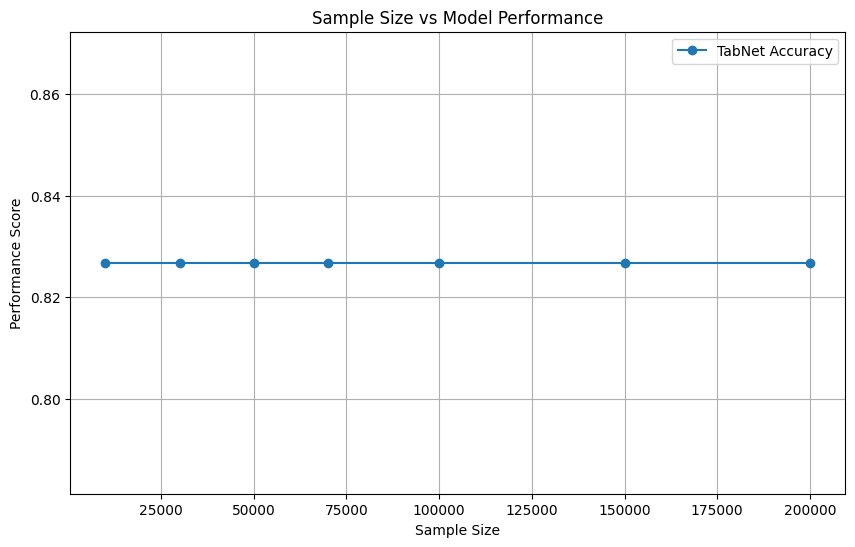

In [35]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, tabnet_results, marker="o", linestyle="-", label="TabNet Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

### Tab_Transformer

In [36]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [37]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [38]:
from torch_frame import numerical, categorical, text_embedded, embedding

data_sizes = [10000, 30000, 50000, 70000, 100000, 150000, 200000]
Tab_Transformer_results = []

for size in data_sizes:
    df = pd.read_csv("thyroid_cancer_risk_data.csv")

    # 데이터 사이즈별 추출 
    df = df.sample(n = size, random_state=42)

    ## 칼럼 별 Dtype 지정 
    col_to_stype={"Age" : numerical,
                "Gender" : categorical,
                "Country" : categorical,
                "Ethnicity" : categorical,
                "Family_History" : categorical,
                "Radiation_Exposure" : categorical,
                "Iodine_Deficiency" : categorical,
                "Smoking" : categorical,
                "Obesity" : categorical,
                "Diabetes" : categorical,
                "TSH_Level" : numerical,
                "T3_Level" : numerical,
                "T4_Level" : numerical,
                "Nodule_Size" : categorical,
                "Thyroid_Cancer_Risk" : categorical,
                "Diagnosis" : categorical}

    dataset = Dataset(df = df, 
                    col_to_stype = col_to_stype, 
                    target_col = "Diagnosis")

    dataset.materialize()
    
    # 여기에 데이터 셋을 나누고 모델을 학습하는 코드 추가
    train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]
    
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    test_tensor_frame = test_dataset.tensor_frame
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
    test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)    

    # Set up model and optimizer
    model = TabTransformer(
        channels=args.channels,
        out_channels= 2,        # stype 문제로 수동으로 설정 
        num_layers=args.num_layers,
        num_heads=args.num_heads,
        encoder_pad_size=args.encoder_pad_size,
        attn_dropout=args.attention_dropout,
        ffn_dropout=args.ffn_dropout,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

    
    # 훈련 및 테스트
    metric = 'ACC'
    best_val_metric = 0
    best_test_metric = 0
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        test_metric = test(test_loader)

        if val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test_metric

        print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
        lr_scheduler.step()

    print(f'Best Val {metric}: {best_val_metric:.4f}, '
          f'Best Test {metric}: {best_test_metric:.4f}')
        
    Tab_Transformer_results.append(best_test_metric)
    

Epoch: 1: 100%|██████████| 24/24 [00:00<00:00, 30.38it/s]


Train Loss: 1.3890, Train ACC: 0.7227, Val ACC: 0.7270, Test ACC: 0.7310


Epoch: 2: 100%|██████████| 24/24 [00:00<00:00, 30.98it/s]


Train Loss: 1.0343, Train ACC: 0.6085, Val ACC: 0.6160, Test ACC: 0.6117


Epoch: 3: 100%|██████████| 24/24 [00:00<00:00, 31.07it/s]


Train Loss: 0.7863, Train ACC: 0.7423, Val ACC: 0.7360, Test ACC: 0.7393


Epoch: 4: 100%|██████████| 24/24 [00:00<00:00, 30.96it/s]


Train Loss: 0.6848, Train ACC: 0.5682, Val ACC: 0.5880, Test ACC: 0.5683


Epoch: 5: 100%|██████████| 24/24 [00:00<00:00, 31.61it/s]


Train Loss: 0.6265, Train ACC: 0.8173, Val ACC: 0.8160, Test ACC: 0.8163


Epoch: 6: 100%|██████████| 24/24 [00:00<00:00, 31.02it/s]


Train Loss: 0.5934, Train ACC: 0.8052, Val ACC: 0.8080, Test ACC: 0.8053


Epoch: 7: 100%|██████████| 24/24 [00:00<00:00, 31.27it/s]


Train Loss: 0.5371, Train ACC: 0.8248, Val ACC: 0.8240, Test ACC: 0.8270


Epoch: 8: 100%|██████████| 24/24 [00:00<00:00, 31.27it/s]


Train Loss: 0.5143, Train ACC: 0.8215, Val ACC: 0.8230, Test ACC: 0.8213


Epoch: 9: 100%|██████████| 24/24 [00:00<00:00, 31.25it/s]


Train Loss: 0.4902, Train ACC: 0.7723, Val ACC: 0.7580, Test ACC: 0.7650


Epoch: 10: 100%|██████████| 24/24 [00:00<00:00, 31.17it/s]


Train Loss: 0.4971, Train ACC: 0.6833, Val ACC: 0.6590, Test ACC: 0.6707


Epoch: 11: 100%|██████████| 24/24 [00:00<00:00, 30.38it/s]


Train Loss: 0.4897, Train ACC: 0.8230, Val ACC: 0.8160, Test ACC: 0.8163


Epoch: 12: 100%|██████████| 24/24 [00:00<00:00, 32.82it/s]


Train Loss: 0.4834, Train ACC: 0.8248, Val ACC: 0.8240, Test ACC: 0.8270


Epoch: 13: 100%|██████████| 24/24 [00:00<00:00, 30.57it/s]


Train Loss: 0.4794, Train ACC: 0.7708, Val ACC: 0.7560, Test ACC: 0.7627


Epoch: 14: 100%|██████████| 24/24 [00:00<00:00, 31.15it/s]


Train Loss: 0.4762, Train ACC: 0.8247, Val ACC: 0.8240, Test ACC: 0.8263


Epoch: 15: 100%|██████████| 24/24 [00:00<00:00, 31.12it/s]


Train Loss: 0.4685, Train ACC: 0.8250, Val ACC: 0.8240, Test ACC: 0.8270
Best Val ACC: 0.8240, Best Test ACC: 0.8270


Epoch: 1: 100%|██████████| 71/71 [00:02<00:00, 31.94it/s]


Train Loss: 1.0526, Train ACC: 0.7423, Val ACC: 0.7383, Test ACC: 0.7370


Epoch: 2: 100%|██████████| 71/71 [00:02<00:00, 32.82it/s]


Train Loss: 0.6339, Train ACC: 0.8231, Val ACC: 0.8157, Test ACC: 0.8234


Epoch: 3: 100%|██████████| 71/71 [00:02<00:00, 31.51it/s]


Train Loss: 0.5300, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 4: 100%|██████████| 71/71 [00:02<00:00, 31.21it/s]


Train Loss: 0.4904, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 5: 100%|██████████| 71/71 [00:02<00:00, 30.85it/s]


Train Loss: 0.4853, Train ACC: 0.7835, Val ACC: 0.7710, Test ACC: 0.7869


Epoch: 6: 100%|██████████| 71/71 [00:02<00:00, 31.78it/s]


Train Loss: 0.4715, Train ACC: 0.8184, Val ACC: 0.8077, Test ACC: 0.8172


Epoch: 7: 100%|██████████| 71/71 [00:02<00:00, 31.07it/s]


Train Loss: 0.4697, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 8: 100%|██████████| 71/71 [00:02<00:00, 31.07it/s]


Train Loss: 0.4676, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 9: 100%|██████████| 71/71 [00:02<00:00, 30.26it/s]


Train Loss: 0.4678, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 10: 100%|██████████| 71/71 [00:02<00:00, 26.75it/s]


Train Loss: 0.4711, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 11: 100%|██████████| 71/71 [00:02<00:00, 30.96it/s]


Train Loss: 0.4665, Train ACC: 0.8254, Val ACC: 0.8160, Test ACC: 0.8260


Epoch: 12: 100%|██████████| 71/71 [00:02<00:00, 32.13it/s]


Train Loss: 0.4670, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 13: 100%|██████████| 71/71 [00:02<00:00, 30.78it/s]


Train Loss: 0.4658, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267


Epoch: 14: 100%|██████████| 71/71 [00:02<00:00, 30.58it/s]


Train Loss: 0.4628, Train ACC: 0.8072, Val ACC: 0.7950, Test ACC: 0.8064


Epoch: 15: 100%|██████████| 71/71 [00:02<00:00, 29.74it/s]


Train Loss: 0.4620, Train ACC: 0.8257, Val ACC: 0.8190, Test ACC: 0.8267
Best Val ACC: 0.8190, Best Test ACC: 0.8267


Epoch: 1: 100%|██████████| 118/118 [00:03<00:00, 30.17it/s]


Train Loss: 0.8973, Train ACC: 0.6655, Val ACC: 0.6534, Test ACC: 0.6655


Epoch: 2: 100%|██████████| 118/118 [00:03<00:00, 30.21it/s]


Train Loss: 0.5541, Train ACC: 0.8253, Val ACC: 0.8216, Test ACC: 0.8223


Epoch: 3: 100%|██████████| 118/118 [00:03<00:00, 31.09it/s]


Train Loss: 0.4874, Train ACC: 0.7994, Val ACC: 0.7964, Test ACC: 0.7958


Epoch: 4: 100%|██████████| 118/118 [00:03<00:00, 30.78it/s]


Train Loss: 0.4738, Train ACC: 0.8253, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 5: 100%|██████████| 118/118 [00:03<00:00, 31.26it/s]


Train Loss: 0.4739, Train ACC: 0.8097, Val ACC: 0.8036, Test ACC: 0.8045


Epoch: 6: 100%|██████████| 118/118 [00:03<00:00, 30.47it/s]


Train Loss: 0.4734, Train ACC: 0.8253, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 7: 100%|██████████| 118/118 [00:03<00:00, 30.49it/s]


Train Loss: 0.4694, Train ACC: 0.8253, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 8: 100%|██████████| 118/118 [00:03<00:00, 30.06it/s]


Train Loss: 0.4730, Train ACC: 0.8253, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 9: 100%|██████████| 118/118 [00:03<00:00, 31.37it/s]


Train Loss: 0.4644, Train ACC: 0.7828, Val ACC: 0.7790, Test ACC: 0.7801


Epoch: 10: 100%|██████████| 118/118 [00:03<00:00, 31.04it/s]


Train Loss: 0.4632, Train ACC: 0.8253, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 11: 100%|██████████| 118/118 [00:03<00:00, 30.41it/s]


Train Loss: 0.4612, Train ACC: 0.7656, Val ACC: 0.7686, Test ACC: 0.7664


Epoch: 12: 100%|██████████| 118/118 [00:03<00:00, 31.03it/s]


Train Loss: 0.4693, Train ACC: 0.8254, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 13: 100%|██████████| 118/118 [00:03<00:00, 30.55it/s]


Train Loss: 0.4705, Train ACC: 0.8253, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 14: 100%|██████████| 118/118 [00:03<00:00, 31.29it/s]


Train Loss: 0.4619, Train ACC: 0.8253, Val ACC: 0.8214, Test ACC: 0.8223


Epoch: 15: 100%|██████████| 118/118 [00:03<00:00, 30.94it/s]


Train Loss: 0.4596, Train ACC: 0.7656, Val ACC: 0.7686, Test ACC: 0.7664
Best Val ACC: 0.8216, Best Test ACC: 0.8223


Epoch: 1: 100%|██████████| 165/165 [00:05<00:00, 30.99it/s]


Train Loss: 0.8091, Train ACC: 0.7030, Val ACC: 0.7007, Test ACC: 0.7020


Epoch: 2: 100%|██████████| 165/165 [00:05<00:00, 31.01it/s]


Train Loss: 0.5071, Train ACC: 0.7610, Val ACC: 0.7601, Test ACC: 0.7656


Epoch: 3: 100%|██████████| 165/165 [00:05<00:00, 30.72it/s]


Train Loss: 0.4795, Train ACC: 0.8247, Val ACC: 0.8243, Test ACC: 0.8295


Epoch: 4: 100%|██████████| 165/165 [00:05<00:00, 29.11it/s]


Train Loss: 0.4739, Train ACC: 0.8247, Val ACC: 0.8243, Test ACC: 0.8295


Epoch: 5: 100%|██████████| 165/165 [00:05<00:00, 32.07it/s]


Train Loss: 0.4719, Train ACC: 0.7666, Val ACC: 0.7657, Test ACC: 0.7707


Epoch: 6: 100%|██████████| 165/165 [00:05<00:00, 31.13it/s]


Train Loss: 0.4682, Train ACC: 0.8241, Val ACC: 0.8237, Test ACC: 0.8290


Epoch: 7: 100%|██████████| 165/165 [00:05<00:00, 31.81it/s]


Train Loss: 0.4688, Train ACC: 0.7666, Val ACC: 0.7657, Test ACC: 0.7707


Epoch: 8: 100%|██████████| 165/165 [00:05<00:00, 31.43it/s]


Train Loss: 0.4717, Train ACC: 0.8247, Val ACC: 0.8243, Test ACC: 0.8295


Epoch: 9: 100%|██████████| 165/165 [00:05<00:00, 31.44it/s]


Train Loss: 0.4664, Train ACC: 0.7666, Val ACC: 0.7657, Test ACC: 0.7707


Epoch: 10: 100%|██████████| 165/165 [00:06<00:00, 26.64it/s]


Train Loss: 0.4630, Train ACC: 0.8247, Val ACC: 0.8243, Test ACC: 0.8295


Epoch: 11: 100%|██████████| 165/165 [00:05<00:00, 31.95it/s]


Train Loss: 0.4639, Train ACC: 0.8247, Val ACC: 0.8243, Test ACC: 0.8295


Epoch: 12: 100%|██████████| 165/165 [00:05<00:00, 32.04it/s]


Train Loss: 0.4646, Train ACC: 0.7666, Val ACC: 0.7657, Test ACC: 0.7707


Epoch: 13: 100%|██████████| 165/165 [00:05<00:00, 30.92it/s]


Train Loss: 0.4598, Train ACC: 0.8186, Val ACC: 0.8170, Test ACC: 0.8217


Epoch: 14: 100%|██████████| 165/165 [00:05<00:00, 31.42it/s]


Train Loss: 0.4632, Train ACC: 0.8247, Val ACC: 0.8243, Test ACC: 0.8295


Epoch: 15: 100%|██████████| 165/165 [00:05<00:00, 31.99it/s]


Train Loss: 0.4602, Train ACC: 0.7666, Val ACC: 0.7657, Test ACC: 0.7707
Best Val ACC: 0.8243, Best Test ACC: 0.8295


Epoch: 1: 100%|██████████| 235/235 [00:06<00:00, 35.39it/s]


Train Loss: 0.7221, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 2: 100%|██████████| 235/235 [00:07<00:00, 30.74it/s]


Train Loss: 0.4807, Train ACC: 0.8007, Val ACC: 0.8052, Test ACC: 0.7999


Epoch: 3: 100%|██████████| 235/235 [00:07<00:00, 31.22it/s]


Train Loss: 0.4760, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 4: 100%|██████████| 235/235 [00:07<00:00, 30.84it/s]


Train Loss: 0.4697, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 5: 100%|██████████| 235/235 [00:07<00:00, 30.82it/s]


Train Loss: 0.4643, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 6: 100%|██████████| 235/235 [00:07<00:00, 30.84it/s]


Train Loss: 0.4673, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 7: 100%|██████████| 235/235 [00:07<00:00, 31.34it/s]


Train Loss: 0.4624, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 8: 100%|██████████| 235/235 [00:07<00:00, 30.32it/s]


Train Loss: 0.4619, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 9: 100%|██████████| 235/235 [00:08<00:00, 27.24it/s]


Train Loss: 0.4612, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 10: 100%|██████████| 235/235 [00:07<00:00, 31.35it/s]


Train Loss: 0.4593, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 11: 100%|██████████| 235/235 [00:07<00:00, 30.61it/s]


Train Loss: 0.4613, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 12: 100%|██████████| 235/235 [00:07<00:00, 31.12it/s]


Train Loss: 0.4577, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 13: 100%|██████████| 235/235 [00:07<00:00, 30.93it/s]


Train Loss: 0.4569, Train ACC: 0.8124, Val ACC: 0.8110, Test ACC: 0.8114


Epoch: 14: 100%|██████████| 235/235 [00:07<00:00, 31.31it/s]


Train Loss: 0.4572, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275


Epoch: 15: 100%|██████████| 235/235 [00:07<00:00, 31.40it/s]


Train Loss: 0.4561, Train ACC: 0.8258, Val ACC: 0.8277, Test ACC: 0.8275
Best Val ACC: 0.8277, Best Test ACC: 0.8275


Epoch: 1: 100%|██████████| 352/352 [00:11<00:00, 30.11it/s]


Train Loss: 0.6398, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 2: 100%|██████████| 352/352 [00:11<00:00, 31.37it/s]


Train Loss: 0.4722, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 3: 100%|██████████| 352/352 [00:11<00:00, 30.90it/s]


Train Loss: 0.4716, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 4: 100%|██████████| 352/352 [00:11<00:00, 31.07it/s]


Train Loss: 0.4645, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 5: 100%|██████████| 352/352 [00:11<00:00, 31.69it/s]


Train Loss: 0.4600, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 6: 100%|██████████| 352/352 [00:11<00:00, 31.50it/s]


Train Loss: 0.4601, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 7: 100%|██████████| 352/352 [00:11<00:00, 31.27it/s]


Train Loss: 0.4575, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 8: 100%|██████████| 352/352 [00:10<00:00, 32.06it/s]


Train Loss: 0.4558, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 9: 100%|██████████| 352/352 [00:11<00:00, 31.90it/s]


Train Loss: 0.4584, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 10: 100%|██████████| 352/352 [00:11<00:00, 31.35it/s]


Train Loss: 0.4586, Train ACC: 0.7677, Val ACC: 0.7659, Test ACC: 0.7697


Epoch: 11: 100%|██████████| 352/352 [00:10<00:00, 32.06it/s]


Train Loss: 0.4571, Train ACC: 0.8208, Val ACC: 0.8149, Test ACC: 0.8209


Epoch: 12: 100%|██████████| 352/352 [00:11<00:00, 31.31it/s]


Train Loss: 0.4563, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 13: 100%|██████████| 352/352 [00:12<00:00, 28.92it/s]


Train Loss: 0.4565, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 14: 100%|██████████| 352/352 [00:10<00:00, 32.11it/s]


Train Loss: 0.4569, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291


Epoch: 15: 100%|██████████| 352/352 [00:11<00:00, 31.78it/s]


Train Loss: 0.4554, Train ACC: 0.8268, Val ACC: 0.8252, Test ACC: 0.8291
Best Val ACC: 0.8252, Best Test ACC: 0.8291


Epoch: 1: 100%|██████████| 469/469 [00:15<00:00, 30.89it/s]


Train Loss: 0.5958, Train ACC: 0.8262, Val ACC: 0.8293, Test ACC: 0.8258


Epoch: 2: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]


Train Loss: 0.4688, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 3: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]


Train Loss: 0.4627, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 4: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s]


Train Loss: 0.4612, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 5: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]


Train Loss: 0.4583, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 6: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]


Train Loss: 0.4565, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 7: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]


Train Loss: 0.4567, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 8: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]


Train Loss: 0.4584, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 9: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]


Train Loss: 0.4568, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 10: 100%|██████████| 469/469 [00:16<00:00, 29.05it/s]


Train Loss: 0.4581, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 11: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]


Train Loss: 0.4567, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 12: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s]


Train Loss: 0.4559, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 13: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]


Train Loss: 0.4559, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 14: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]


Train Loss: 0.4560, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268


Epoch: 15: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]


Train Loss: 0.4563, Train ACC: 0.8271, Val ACC: 0.8304, Test ACC: 0.8268
Best Val ACC: 0.8304, Best Test ACC: 0.8268


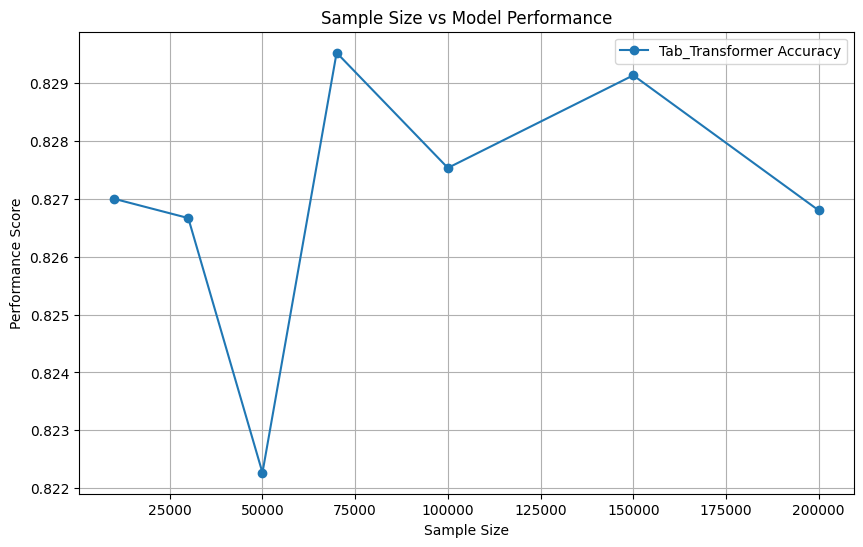

In [39]:
# ✅ 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, Tab_Transformer_results, marker="o", linestyle="-", label="Tab_Transformer Accuracy")


#plt.xscale("log")  # 로그 스케일 적용 (샘플 크기가 큰 차이가 나기 때문)
plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

# 시각화

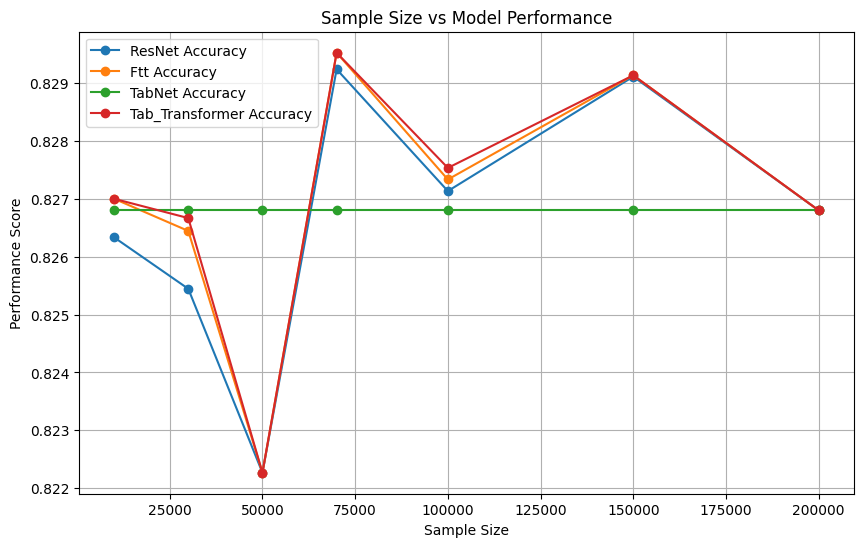

In [40]:
# 종합 시각화 결과 . 
plt.figure(figsize=(10, 6))

plt.plot(data_sizes, resnet_results, marker="o", linestyle="-", label="ResNet Accuracy")
plt.plot(data_sizes, ftt_results, marker="o", linestyle="-", label="Ftt Accuracy")
plt.plot(data_sizes, tabnet_results, marker="o", linestyle="-", label="TabNet Accuracy")
plt.plot(data_sizes, Tab_Transformer_results, marker="o", linestyle="-", label="Tab_Transformer Accuracy")


plt.xlabel("Sample Size")
plt.ylabel("Performance Score")
plt.title("Sample Size vs Model Performance")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
resnet_results

[0.8263333333333334,
 0.8254444444444444,
 0.8222666666666667,
 0.8292380952380952,
 0.8271333333333334,
 0.8291111111111111,
 0.8268]

In [42]:
ftt_results

[0.827,
 0.8264444444444444,
 0.8222666666666667,
 0.8295238095238096,
 0.8273333333333334,
 0.8291333333333334,
 0.8268]

In [43]:
tabnet_results

[0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.8268, 0.8268]

In [44]:
Tab_Transformer_results

[0.827,
 0.8266666666666667,
 0.8222666666666667,
 0.8295238095238096,
 0.8275333333333333,
 0.8291333333333334,
 0.8268]